In [18]:
import numpy as np 
from itertools import product
import timeit
from scipy.stats import binom
import matplotlib.pyplot as plt
%matplotlib inline


starttime = timeit.default_timer()

S0 = 50; u = 1.06; r = 0.01; d = 0.98; n = 26; M = 25

def permgrid(n, u, d):
    inds = np.indices((2,) * n)
    inds = inds.reshape(n, -1).T
    inds = d*inds
    return np.where(inds == 0, u, inds)

def binomialPath(M):
    PQ = permgrid(M, u, d)
    S = np.zeros((2**n, n+1))
    S[:, 0] = S0 
    
    for i in range(n):
        S[:, i+1] = S[:, i]*PQ[:, i]
              
    return S 

def genPath(M):
    q = (1+r-d)/(u-d)
    S = PQ = np.zeros((M, n+1))
    S[:, 0] = S0
    
    for i in range(M):
        UUi = np.random.uniform(size = M)
        upow = (UUi < q).astype(int)
        dpow = (UUi >= q).astype(int)
        for j in range(n):
            S[i, j+1] = S[i, j]* u**upow[j] * d**dpow[j]
            PQ[i, j+1] = q**upow[j] * (1-q)**dpow[j]
    
    return S, PQ

    
    
S, PQ = genPath(26)
M = n = 8
testing = binomialPath(M)


print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.009838773985393345


4. Consider the up-and-in barrier Call: it pays $V_N = (S_N - K)_+$ but only if $\text{max}_n S_n > B$, i.e. at some point between 0 and $T$, the stock price exceeded the level $B$. If this happens, we say that the option got "knocked in". The barrier option is path-dependent. Take a binomial tree with $u=1.05, \; d=0.95,\; r=0.01$ and $N=8$. The barrier parameters are $S_0 = 10, \; K=11$ and $B$ to be specified below. There are a total of $2^N=256$ scenarios in this tree. By directly enumerating them as $\omega^{(1)}=HHHHHHHH,\; \omega^{(2)}=HHHHHHHT,\;..., \; \omega^{(256)}=TTTTTTTT$ and computing $\mathbb{Q}(\omega^{(i)})$, find the price of the up-and-in barrier Call: 
$$\mathbb{E}^Q \bigg [\frac{V_N}{(1+r)^N} \bigg ]  = \frac{1}{(1+r)^N} \sum^{256}_{i=1} \mathbb{Q}(\omega^{(i)})V_N(\omega^{(i)})$$

    The provided R code in class shows how to enumerate the scenarios by translating between the index $i$ of $\omega^{(i)}$ and the individual coin tosses $\omega^{(i)}_k$. As an example, it computes the final stock price $S_N(\omega_1...\omega_N).$ You will need to modify the code to compute the barrier Call payoffs. 

    For each $B = 11, 11.5, 12, 12.5, 13$ report: (i) number of scenarios that have nonzero payoff; (ii) risk-neutral probability of being knocked-in, (iii) no-arbitrage price of the barrier Call.
    Note: if $B = 11 = K$ then the barrier feature doesn’t do anything and the answer you get is the same as for ordinary Call.

In [10]:
import numpy as np
import pandas as pd 
u = 1.05; d = 0.95; r = 0.01; n = 8; S0 = 10; M = 8; K = 11
q = (1+r-d)/(u-d)

def permgrid(n, u, d):
    inds = np.indices((2,) * n)
    inds = inds.reshape(n, -1).T
    inds = d*inds
    return np.where(inds == 0, u, inds)

def binomialPath(M):
    PQ = permgrid(M, u, d)
    S = np.zeros((2**n, n+1))
    S[:, 0] = S0 
    
    for i in range(n):
        S[:, i+1] = S[:, i]*PQ[:, i]
              
    return S 

PQ = permgrid(M, u, d)    
S = binomialPath(M)

def barrier_payoff(B):
    
    Payoff = np.zeros(2**M)
    count = 0 
    PQ = permgrid(M, u, d)
    PQ = np.where(PQ == u, q, PQ)
    PQ = np.where(PQ == d, 1-q, PQ)
    for i in range(M):
        if max(S[i, :]) > B:
            Payoff[i] = max(S[i, n] - K, 0)
            if Payoff[i] > 0:
                count += 1 
    price = sum(Payoff*PQ[:, n-1])/(1+r)**n 
    prob = q**count * (1-q)**(M-count)
    
    return price, count, prob 

print(barrier_payoff(11))
print(barrier_payoff(11.5))
print(barrier_payoff(12))
print(barrier_payoff(12.5))
print(barrier_payoff(13))

(7.004405538595183, 7, 0.011197439999999998)
(7.004405538595183, 7, 0.011197439999999998)
(7.004405538595183, 7, 0.011197439999999998)
(7.004405538595183, 7, 0.011197439999999998)
(5.993779524134783, 5, 0.00497664)


2\. Consider a binomial tree with $S_0 = 50, u = 1.06, r = 0.01, d = 0.98$ (all values per period) and $n = 26$ periods.

a. Generate a sample of $M = 25$ values of $S_{26}$. Compute the resulting Monte Carlo estimate for the value of a European Put which has strike $K = 60$. Provide both the
point estimate based on sample average, as well as a 95% confidence interval based on
the t-distribution of the sample average estimator.

In [289]:
np.random.seed(1)

S0 = 50; u = 1.06; r = 0.01; d = 0.98; n = 26; M = 25; K = 60

def MC_euro_put_payoff(K):
    U = np.random.uniform(size = M)
    S = Payoff = np.zeros(M)
    q = (1+r-d)/(u-d)

    for i in range(M):
        S[i] = S0*(u/d)**(binom.ppf(U[i], n, q))*d**n
        Payoff[i] = max(K-S[i], 0)
    
    return Payoff 

def ptEstimate_and_95CI(K, Payoff):
    
    discountedPayoff = Payoff/(1+r)**n
    Vhat = np.mean(discountedPayoff)

    CI = (Vhat-2.060*np.std(discountedPayoff)/np.sqrt(M), 
         Vhat+2.060*np.std(discountedPayoff)/np.sqrt(M))
    
    return Vhat, CI

Vhat, CI = ptEstimate_and_95CI(K, MC_euro_put_payoff(K))

print('The point estimate is %s.'%Vhat)
print('The 95-percent CI is %s.'%(CI,))

The point estimate is 2.6829218905543364.
The 95-percent CI is (0.7502105981849123, 4.6156331829237605).


b. Repeat the above 10 times and summarize your results. Be sure to compare your MC estimates to the true no-arbitrage price of this Put (which is the direct expectation
using the distribution in (a)).

In [290]:
import pandas as pd

K = 60
everything = list()

for i in range(10):
    everything.append(ptEstimate_and_95CI(K, MC_euro_put_payoff(K)))

Vhats, CIs = zip(*everything)
    
allS = S0*(u/d)**np.arange(n)*d**n
put_payoff = lambda s: max(K - s, 0)

allS_payoffs = np.array(list(map(put_payoff, allS)))
truePrice = sum(allS_payoffs*binom.pmf(np.arange(n), n, q))/(1+r)**n
truePriceSq = sum(allS_payoffs**2*binom.pmf(np.arange(n), n, q))/(1+r)**(2*n)
trueSd = np.sqrt(truePriceSq - truePrice**2)
print('True mean price: %s\nTrue standard deviation: %s'%(truePrice, trueSd))   

pd.DataFrame({'Point Estimate':Vhats, '95-percent CI':CIs, 
              'Abs. Error of Point Estimate':list(map(abs, Vhats - truePrice))},
            index = list(range(1,11)))

True mean price: 2.123586766322793
True standard deviation: 3.6851920061217203


,Point Estimate,95-percent CI,Abs. Error of Point Estimate
1,2.801249,"(1.209202787358666, 4.39329583692839)",0.677663
2,2.659100,"(1.0526701548470043, 4.265529862866649)",0.535513
3,1.536658,"(-0.031469540452262246, 3.104786024883026)",0.586929
4,3.355542,"(1.3507046965348235, 5.360379093033799)",1.231955
5,3.399286,"(1.5423340209423027, 5.256237264961017)",1.275699
6,2.127113,"(0.6279440140105548, 3.6262810900553877)",0.003526
7,2.528286,"(0.967117467336458, 4.0894547819640135)",0.404699
8,2.368287,"(0.7131129404393837, 4.023461666458105)",0.244701
9,1.185907,"(-0.096884573257777, 2.4686976193919916)",0.937680
10,0.946678,"(-0.6489341074535336, 2.542290673842027)",1.176908


c) Repeat parts a-b for the European Call with strike K = 80. How is this new case different from before?        

In [291]:
def MC_Euro_call_payoff(K):
    U = np.random.uniform(size = M)
    S = Payoff = np.zeros(M)
    q = (1+r-d)/(u-d)

    for i in range(M):
        S[i] = S0*(u/d)**(binom.ppf(U[i], n, q))*d**n
        Payoff[i] = max(S[i]-K, 0)
    
    return Payoff 

K = 80 
Vhat, CI = ptEstimate_and_95CI(K, MC_Euro_call_payoff(K))
print('The point estimate is %s.'%Vhat)
print('The 95-percent CI is %s.'%(CI,))

everything = list()

for i in range(10):
    everything.append(ptEstimate_and_95CI(K, MC_Euro_call_payoff(K)))

Vhats, CIs = zip(*everything)
    
allS = S0*(u/d)**np.arange(n)*d**n
call_payoff = lambda s: max(s - K, 0)

allS_payoffs = np.array(list(map(call_payoff, allS)))
truePrice = sum(allS_payoffs*binom.pmf(np.arange(n), n, q))/(1+r)**n
truePriceSq = sum(allS_payoffs**2*binom.pmf(np.arange(n), n, q))/(1+r)**(2*n)
trueSd = np.sqrt(truePriceSq - truePrice**2)
print('\nTrue mean price: %s\nTrue standard deviation: %s'%(truePrice, trueSd))   

pd.DataFrame({'Point Estimate':Vhats, '95-percent CI':CIs, 
              'Abs. Error of Point Estimate':list(map(abs, Vhats - truePrice))},
            index = list(range(1,11)))

The point estimate is 0.6169256972069234.
The 95-percent CI is (-0.38197167534668863, 1.6158230697605354).

True mean price: 0.8114443935649318
True standard deviation: 3.040950280803362


,Point Estimate,95-percent CI,Abs. Error of Point Estimate
1,0.186540,"(-0.021582952090738988, 0.3946635812044711)",0.624904
2,0.331114,"(-0.22089812003498882, 0.8831260639510612)",0.480330
3,2.023651,"(-0.19649211467629435, 4.243794300906761)",1.212207
4,0.734453,"(-0.747951659998821, 2.2168571607594196)",0.076992
5,0.537868,"(-0.2136195366923498, 1.2893550051153397)",0.273577
6,0.455474,"(-0.11103050758335126, 1.0219788709085782)",0.355970
7,1.682492,"(-0.10476967489747957, 3.469754513987998)",0.871048
8,0.517654,"(-0.05424062738780511, 1.0895492004176095)",0.293790
9,1.550832,"(-0.651029188017364, 3.7526921972640306)",0.739387
10,1.477696,"(-0.17097136364708643, 3.126364288661163)",0.666252


3\. Consider a Lookback option which pays $V_N = \text{max}(\text{max}_{n\leq N} S_n-K, 0)$ where $\text{max}_{n\leq N} S_n = 
\text{max}(S_0, S_1,..., S_N)$ is the maximum stock price over $N$ periods. For the parameters, $S_0 = 50, r = 0.01, u = 1.06, d = 0.98, K = 55$ and $N = 30$, estimate the no-arbitrage
value of this option at $t = 0$ using a Monte Carlo simulation with $M = 100$ samples. Be sure to use antithetic variables, and generate your samples in pairs.

Hand-in: 
    
a) the code you used.

b) a histogram of the resulting values of option payoff $V_N$.

c) Sample mean/SD of your payoffs.

d) Final answer with a 99% - confidence interval.

In [292]:
# a

S0 = 50; u = 1.06; r = 0.01; d = 0.98; N = 30; M = 100; K = 55

def binomConvert(UUi, q):
    upow = (UUi < q).astype(int)
    dpow = (UUi >= q).astype(int)
    
    return upow, dpow 
         
def antithetic_path(M):
    q = (1+r-d)/(u-d)
    S = np.zeros((2*M, N+1))
    discountedPayoffs = np.zeros(M)
    S[:, 0] = S0
    
    for i in range(N):
        UUi = np.random.uniform(size = M)
        upow, dpow = binomConvert(UUi, q)

        U_anti = 1 - UUi
        upow1, dpow1 = binomConvert(U_anti, q)
        
        S[0:M, i+1] = S[0:M, i] * u**upow * d**dpow
        S[M:2*M, i+1] = S[0:M, i] * u**upow1 * d**dpow1
                
    return S

(0.0, 50.0)

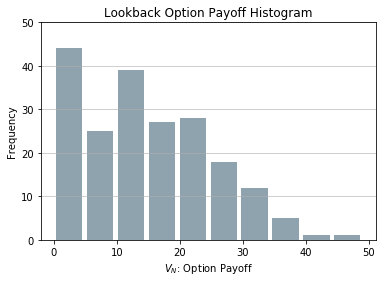

In [295]:
# b

S = gen_antithetic_path(M)

discountedPayoffs = [1/(1+r)**N * max(max(S[i, :]) - K, 0) 
                            for i in range(2*M)]

n, bins, patches = plt.hist(x=discountedPayoffs, bins='auto', 
                            color='#607c8e', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha = 0.75)
plt.xlabel('$V_N$: Option Payoff')
plt.ylabel('Frequency')
plt.title('Lookback Option Payoff Histogram')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [296]:
# c

sample_mean = np.mean(discountedPayoffs)
sample_std = np.std(discountedPayoffs)

print('Sample mean: %s'%sample_mean)
print('Sample standard deviation: %s'%sample_std)

Sample mean: 14.453217117944009
Sample standard deviation: 10.25912634345684


In [297]:
# d

CI = (sample_mean-2.58*sample_std/np.sqrt(M), 
         sample_mean+2.58*sample_std/np.sqrt(M))

print('The 99-percent CI is %s.'%(CI,))

The 99-percent CI is (11.806362521332144, 17.100071714555874).


4\. The Black-Scholes model assumes that 

$$S_T = S_0 exp((r-0.5\sigma^2)T + \sigma \sqrt{T}Z)$$

where $Z$ is standard normal, independent of everything else and $\sigma$ is the model parameter.


Consider a European Call with strike $K = 45$ and maturity $T = 1/2$ for an asset with $S_0 = 50, \sigma= 0.2$. The interest rate is $r = 0.04$ (here all parameters are in annual units). Because this is a European contract, for Monte Carlo purposes we can directly sample from the log-normal distribution of $S_T$. [As a reference, see pp. 4–6 in Glasserman
Chapter 1]

a) Using a sample of 25 Monte Carlo values (use the basic method, without any enhancements) for $S_T$ , estimate the value of this European Call and a 95% confidence interval.
Compare to the true Black-Scholes price of the Call.

In [299]:
K = 45; T = 1/2; S0 = 50; sigma = 0.2; r = 0.04; M = 25

def MC_bs_euro_call_payoff():
    
    ST = discountedPayoff = np.zeros(M)
    for i in range(M):
        Z = np.random.normal(0,1)
        ST[i] = S0*np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
        discountedPayoff = max(ST[i] - K, 0)/(1 + r)**T
    
    return discountedPayoff

Payoff = MC_bs_euro_call_payoff()
Vhat, CI = ptEstimate_and_95CI(K, Payoff)

print('The point estimate is %s.'%Vhat)
print('The 95-percent CI is %s.'%(CI,))

allS = S0*(u/d)**np.arange(n)*d**n
call_payoff = lambda s: max(s - K, 0)

allS_payoffs = np.array(list(map(call_payoff, allS)))
truePrice = sum(allS_payoffs*binom.pmf(np.arange(n), n, q))/(1+r)**n
truePriceSq = sum(allS_payoffs**2*binom.pmf(np.arange(n), n, q))/(1+r)**(2*n)
trueSd = np.sqrt(truePriceSq - truePrice**2)

print('\nTrue Black-Scholes price of the Call: %s\nTrue standard deviation: %s'%(truePrice, trueSd))   


The point estimate is 5.73695122810017.
The 95-percent CI is (4.489648821858237, 6.984253634342103).


b) Quasi-Monte Carlo: take $U = {0.02, 0.06, . . . , 0.98}$ to be a grid of length 25 in [0,1]. Use the inverse cdf method to compute the corresponding $S_T$ values ( eg the first
sample is the 2% percentile of the standard normal, then use $qnorm()$ command to get the corresponding Z-value and plug into (1)). Average the resulting 25 payoffs to come up with a deterministic estimate of the Call price. Since the answer is deterministic, there is no confidence interval, just a point estimate.
Show your work/code and discuss the results in relation to part a)

In [47]:
U = np.arange(0, 1, 0.02)
U

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])

5\. Basket options have payoffs that depend on the value of multiple underlying assets. For example, consider a payoff based on the Dow Jones Industrial Average. The DJIA is a price-weighted index, namely $$DJIA(T) = \frac{\sum_i S^i(T)}{0.146}$$ where $S^i(T)$ ) is the share price of the i-th component of the index. See wikipedia.org/wiki/Dow_Jones_Industrial_Average#Calculation The real-world Dow has 30 components, but for our purposes we will take $I = 5$ components. Assume that $S^i(0) = 10∗i$ (i.e. $S^1(0) = 10, S^2(0) = 20$ and so on), and each component follows an independent
Black-Scholes model (1) with $r = 0.03$ and $\sigma_i = 0.1 + 0.05 ∗ i$. Thanks to independence, simulation of $S^i(T)$ is straightforward (you just need to loop over $i$ and use the correct volatility $\sigma_i$).
There are no analytic formulas for Basket option values. Using Monte Carlo with $M = 500$, price a Basket Put with payoff $$V_T = max(\frac{S^(T)+S^2(T)+S^3(T)+S^4(T)+S^5(T)}{5}-30, 0), \; r = 0.03, \; T=1.$$ Submit your code, histogram of the contract payoffs, estimated contract value today,
and respective 98% CI.

In [300]:
1210.9*2.5178

3048.80402

6\. Consider the CEV model $$dS_t = rS_tdt + \sigma S^\sigma_tdW_t.$$ This is a generalization of the GBM model that underlies (1) which has $\alpha = 1.$ A path of $S_t$ can be simulated using an Euler method: $$S_{t+\delta t} = S_t + r S_t \delta t + \sigma(S_t)^\alpha Z_{\delta t}, \; Z_{\delta t}~N(0, \delta t) \; i.i.d.$$ (Note that the above is already under the risk-neutral measure Q)
Using Monte Carlo with antithetic paths, price a Hit Box option (see Hw1) on ($S_t$) across the period $T_1 = 1, T_2 = 2$ and levels $\underline{S} = 95, \overline{S}=97.$ Use $\delta t = 0.05$ and $r=0.05, \sigma=0.3, S_0=100$ with CEV-coefficient $\alpha = 0.8$. 

Pick a large M

In [35]:
s = np.array([[100, 154, 320, 230, 168],
[100, 55, 65, 75, 56],
[100, 194, 270, 215, 137],
[100, 105, 123, 135, 109],
[100, 87, 82, 96, 101],
[100, 70, 65, 82, 114],
[100, 111.7023435, 77.83686686, 89.90379786, 109.6277116],
[100, 85.37067741, 116.8306191, 96.4572771, 75.43340288]])


In [36]:
payoff = np.zeros(len(s))
for i in range(len(s)):
    payoff[i] = max(125 - sum(s[i, :])/5, 0)*np.exp(-0.03)
    

In [37]:
np.mean(payoff)

23.456573575851074

In [39]:
temp = np.array([[100, 154, 320, 230, 168],
[100, 55, 65, 75, 56],
[100, 194, 270, 215, 137],
[100, 105, 123, 135, 109],
[100, 87, 82, 96, 101],
[100, 70, 65, 82, 114],
[100, 111.7023435, 77.83686686, 89.90379786, 109.6277116],
[100, 85.37067741, 116.8306191, 96.4572771, 75.43340288]])

In [40]:
temp-1

array([[ 99.        , 153.        , 319.        , 229.        ,
        167.        ],
       [ 99.        ,  54.        ,  64.        ,  74.        ,
         55.        ],
       [ 99.        , 193.        , 269.        , 214.        ,
        136.        ],
       [ 99.        , 104.        , 122.        , 134.        ,
        108.        ],
       [ 99.        ,  86.        ,  81.        ,  95.        ,
        100.        ],
       [ 99.        ,  69.        ,  64.        ,  81.        ,
        113.        ],
       [ 99.        , 110.7023435 ,  76.83686686,  88.90379786,
        108.6277116 ],
       [ 99.        ,  84.37067741, 115.8306191 ,  95.4572771 ,
         74.43340288]])

%
